<a href="https://colab.research.google.com/github/myresearch-ai/Catastrophic-Forgetting-Demonstration-using-Variational-Autoencoders-and-PyTorch/blob/main/VAECatastrophic_Forgetting_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Catastrophic Forgetting in Neural Networks: An Open Problem
---
The field of Artificial Intelligence has experienced substantial growth and development, particularly in the realm of deep learning and neural networks. However, despite the impressive feats achieved by these models, they are not without their challenges. One of the most significant, yet often overlooked issues in the field is 'Catastrophic Forgetting'.

## What is Catastrophic Forgetting?

Catastrophic forgetting, also known as catastrophic interference, refers to the tendency of an artificial neural network to entirely and abruptly forget previously learned information upon learning new data. This phenomenon is a significant barrier to the development of continual or lifelong machine learning, where the goal is for a model to learn from a stream of data continually, building upon past knowledge and adapting to new tasks, much like how humans learn.

## Demonstrating Catastrophic Forgetting

To better understand this, let's consider an experiment where we use a Variational Autoencoder (VAE), a type of neural network used for generating new data, and train it on two distinct image datasets: MNIST and FashionMNIST.

Initially, we train the VAE on the MNIST dataset, which consists of images of handwritten digits. Upon evaluation, the VAE performs well in reconstructing these digits. However, when we subsequently train the VAE on the FashionMNIST dataset, which comprises images of clothing items, a significant problem arises. The VAE tends to forget the information about the MNIST dataset it was initially trained on, resulting in a severe degradation in its ability to reconstruct the handwritten digits. This phenomenon is the essence of catastrophic forgetting.

## Is Catastrophic Forgetting Still an Open Problem?

Yes, catastrophic forgetting remains an open problem in the field of AI. While various techniques have been proposed to mitigate this issue, including methods like Elastic Weight Consolidation (EWC) and Progressive Neural Networks (PNNs), none have been able to entirely eliminate this problem.

## Why Should We Solve Catastrophic Forgetting?


The inability of neural networks to retain previously learned knowledge while learning new tasks limits their applicability in real-world, dynamic environments. For AI to reach its full potential, we need models that can learn continuously, adapt to new tasks, and build upon previous knowledge without forgetting it. This need makes solving catastrophic forgetting a critical endeavor for the advancement of the field.

For instance, consider a personal assistant AI that needs to learn new user preferences over time while retaining its understanding of the user's previous preferences. If catastrophic forgetting is not addressed, the AI might start ignoring old preferences each time it learns new ones, leading to a poor user experience. In a more critical scenario, such as a self-driving car learning to navigate new environments, forgetting previously learned information could have severe consequences.

Moreover, solving catastrophic forgetting could bring AI systems a step closer to the way biological systems learn, leading to more efficient and robust learning mechanisms. Human brains, for instance, can learn new skills or knowledge while retaining old ones, and often the old and new information complement each other.

In conclusion, while we've made significant strides in the field of AI, overcoming catastrophic forgetting stands as one of the key challenges that we need to address. Doing so will unlock a new level of versatility and adaptability in AI systems, enabling them to learn and grow more akin to biological entities. This endeavor is not just about improving our AI models; it's about taking a significant leap forward in our understanding of both artificial and natural learning systems.

In [1]:
%%capture
!pip install torch torchvision

import torch
from torch import nn
from torchvision import datasets, transforms, utils  # added utils here
from torch.optim import Adam
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In the following example, we will use MNIST and FashionMNIST datasets to illustrate catastrophic forgetting in a Variational Autoencoder (VAE). First, we will train the VAE on MNIST, then we will continue training on FashionMNIST. If the VAE forgets the information about MNIST when trained on FashionMNIST, it will demonstrate catastrophic forgetting.

Please note that this is a simplified demonstration and does not involve advanced techniques to prevent catastrophic forgetting.

First, let's define the VAE model:

In [2]:

class VAE(nn.Module):
    def __init__(self, input_size=784, hidden_size=400, latent_size=20):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)  # mu layer
        self.fc22 = nn.Linear(hidden_size, latent_size)  # logvariance layer
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)
        
    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [3]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # The VAE loss is the BCE loss plus the KLD divergence loss.
    return BCE + KLD

Next, let's define a function to train our model:

##**Experiment:**

In [4]:

def train(model, dataset, epochs=10):
    optimizer = Adam(model.parameters(), lr=1e-3)
    train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
    model.train()

    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    loss.item() / len(data)))

Now, let's train the model on the MNIST dataset:

In [5]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE().to(device)
mnist_data = datasets.MNIST('data', train=True, download=True,
                            transform=transforms.ToTensor())

train(model, mnist_data, epochs=10)


Train Epoch: 0 [0/60000]	Loss: 551.102478
Train Epoch: 0 [12800/60000]	Loss: 183.638931
Train Epoch: 0 [25600/60000]	Loss: 154.259888
Train Epoch: 0 [38400/60000]	Loss: 142.089127
Train Epoch: 0 [51200/60000]	Loss: 136.049286
Train Epoch: 1 [0/60000]	Loss: 128.816895
Train Epoch: 1 [12800/60000]	Loss: 122.318924
Train Epoch: 1 [25600/60000]	Loss: 125.058090
Train Epoch: 1 [38400/60000]	Loss: 123.316559
Train Epoch: 1 [51200/60000]	Loss: 121.746353
Train Epoch: 2 [0/60000]	Loss: 116.637428
Train Epoch: 2 [12800/60000]	Loss: 116.874741
Train Epoch: 2 [25600/60000]	Loss: 116.450974
Train Epoch: 2 [38400/60000]	Loss: 108.616371
Train Epoch: 2 [51200/60000]	Loss: 111.556137
Train Epoch: 3 [0/60000]	Loss: 109.500092
Train Epoch: 3 [12800/60000]	Loss: 110.688339
Train Epoch: 3 [25600/60000]	Loss: 110.731201
Train Epoch: 3 [38400/60000]	Loss: 109.317917
Train Epoch: 3 [51200/60000]	Loss: 117.292938
Train Epoch: 4 [0/60000]	Loss: 110.538399
Train Epoch: 4 [12800/60000]	Loss: 109.844025
Train Ep

After training the model on both datasets, we can plot the recorded losses:

After training on MNIST, we will evaluate the model on some samples from the MNIST test set to ensure it has learned to reconstruct them properly:

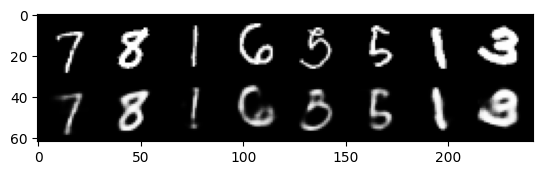

In [6]:

def evaluate(model, dataset):
    model.eval()
    test_loader = DataLoader(dataset, batch_size=16, shuffle=True)
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon_batch, _, _ = model(data)

        n = min(data.size(0), 8)
        comparison = torch.cat([data[:n],
                              recon_batch.view(16, 1, 28, 28)[:n]])
        comparison = comparison.cpu()
        plt.imshow(utils.make_grid(comparison).numpy().transpose(1,2,0))  # changed torchvision.utils.make_grid to utils.make_grid
        plt.show()


mnist_test_data = datasets.MNIST('data', train=False, transform=transforms.ToTensor())
evaluate(model, mnist_test_data)

Now, let's train the model on the FashionMNIST dataset:

In [7]:
fashion_data = datasets.FashionMNIST('data', train=True, download=True,
                                     transform=transforms.ToTensor())

train(model, fashion_data, epochs=10)

Train Epoch: 0 [0/60000]	Loss: 826.753662
Train Epoch: 0 [12800/60000]	Loss: 282.744720
Train Epoch: 0 [25600/60000]	Loss: 278.316528
Train Epoch: 0 [38400/60000]	Loss: 268.954712
Train Epoch: 0 [51200/60000]	Loss: 276.524780
Train Epoch: 1 [0/60000]	Loss: 270.857391
Train Epoch: 1 [12800/60000]	Loss: 258.166992
Train Epoch: 1 [25600/60000]	Loss: 249.855667
Train Epoch: 1 [38400/60000]	Loss: 254.524719
Train Epoch: 1 [51200/60000]	Loss: 252.619843
Train Epoch: 2 [0/60000]	Loss: 246.620911
Train Epoch: 2 [12800/60000]	Loss: 247.653351
Train Epoch: 2 [25600/60000]	Loss: 263.868103
Train Epoch: 2 [38400/60000]	Loss: 245.395126
Train Epoch: 2 [51200/60000]	Loss: 246.732681
Train Epoch: 3 [0/60000]	Loss: 252.006958
Train Epoch: 3 [12800/60000]	Loss: 246.639420
Train Epoch: 3 [25600/60000]	Loss: 248.123337
Train Epoch: 3 [38400/60000]	Loss: 255.812256
Train Epoch: 3 [51200/60000]	Loss: 255.988113
Train Epoch: 4 [0/60000]	Loss: 237.392212
Train Epoch: 4 [12800/60000]	Loss: 253.948730
Train Ep

After training on FashionMNIST, we will evaluate the model again on the MNIST test set. If the model has experienced catastrophic forgetting, the quality of the reconstructions will have significantly degraded:

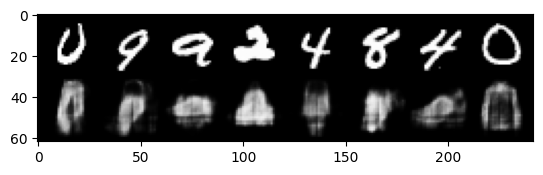

In [8]:

evaluate(model, mnist_test_data)

This setup should demonstrate catastrophic forgetting in a VAE. The model initially learns to reconstruct digits from the MNIST dataset, but after training on the FashionMNIST dataset, it forgets how to reconstruct the digits.

Please note that PyTorch's stochastic nature may lead to varying results, and you might need to adjust the number of epochs or other parameters to clearly see the catastrophic forgetting. Also, in practice, you would want to use more sophisticated techniques to prevent catastrophic forgetting when training on multiple datasets.

## Validity of Experiment:
---

MNIST and FashionMNIST are not considered to be from the same domain. While they share similarities in terms of their structure (both are grayscale image datasets, with the same image size and number of classes), the type of content they represent is quite different.

MNIST contains images of handwritten digits (0-9), while FashionMNIST contains images of clothing items (such as shirts, dresses, sneakers, etc.). The patterns and features that a model would need to learn to accurately classify or reconstruct these images are quite different.

In the context of this experiment, this difference in domain is important. Catastrophic forgetting is particularly prominent when a model is trained sequentially on different tasks or different types of data. In this case, the model is first trained on MNIST (a digit recognition task), and then on FashionMNIST (a clothing item recognition task). The fact that the model's performance on the MNIST dataset degrades after training on FashionMNIST is indicative of catastrophic forgetting.

This experiment is valid as a demonstration of catastrophic forgetting, as it showcases how a model's performance on one task can degrade when it is subsequently trained on a different task. This is a fundamental challenge in machine learning, particularly in continual or lifelong learning scenarios where a model is expected to learn from a stream of data over time.

## Why Deep Learning Networks Catastrophically Forget:
---

Catastrophic forgetting in neural networks occurs because of the way these networks learn. At their core, neural networks adjust their parameters (or weights) based on the data they're exposed to during training. These weight adjustments are the network's way of "remembering" what it has learned.

However, the training process isn't designed to protect older knowledge. When a network learns new data, it adjusts its weights to minimize the error related to the new data. If the new data is very different from the old data, the adjustments needed to learn the new data can significantly disrupt the weights, hence compromising the network's ability to recall the old data. This is the essence of catastrophic forgetting.

To put it more simply, you can imagine a neural network as being a bit like a person who is trying to memorize a list of facts. If the person is given a new list of completely different facts to memorize, they might overwrite the old facts in their memory in the process of memorizing the new ones, especially if they are not reminded of the old facts while learning the new ones. This is akin to what happens in catastrophic forgetting.

The example with the Variational Autoencoder (VAE) trained on MNIST and then on FashionMNIST serves to illustrate this. The VAE starts by learning to generate images of digits (MNIST), and it adjusts its weights to perform well on this task. When it's later trained on images of clothing items (FashionMNIST), it needs to adjust its weights significantly because generating images of clothing items is a different task than generating images of digits. These adjustments disrupt its ability to generate images of digits, hence demonstrating catastrophic forgetting.

It's important to note that while humans and animals can also forget, they have mechanisms to protect important knowledge and skills from being completely overwritten, a trait which current neural networks lack but is an active area of research.